In [1]:
import gzip
import json
from tqdm import tqdm
import gzip
import _pickle as cPickle
import sys
from urllib.request import urlopen, Request

import nltk
from nltk import ngrams

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk import ngrams

sentence = 'this is a foo bar sentences and i want to ngramize it'

n = 6
sixgrams = ngrams(sentence.split(), n)

for grams in sixgrams:
  print(grams)

('this', 'is', 'a', 'foo', 'bar', 'sentences')
('is', 'a', 'foo', 'bar', 'sentences', 'and')
('a', 'foo', 'bar', 'sentences', 'and', 'i')
('foo', 'bar', 'sentences', 'and', 'i', 'want')
('bar', 'sentences', 'and', 'i', 'want', 'to')
('sentences', 'and', 'i', 'want', 'to', 'ngramize')
('and', 'i', 'want', 'to', 'ngramize', 'it')


In [4]:
%%time

def get_contexts(file_path):
    contexts = []
#     single_file_path_cached = cached_path(file_path)
    
    with urlopen(Request(file_path,
                     headers={"Accept-Encoding": "gzip"})) as response, \
     gzip.GzipFile(fileobj=response) as myzip:
        
#     with gzip.open(file_in_memory, 'rb') as myzip:
#     with open(file_path, 'rb') as myzip:
        for example in myzip:
            context = json.loads(example)
            if 'header' in context:
                continue
            contexts.append(context['context'])

    return contexts

def write_distribution_pickle(filename, frequency_distribution):
    with gzip.GzipFile(filename, 'w') as f:
        cPickle.dump(frequency_distribution, f)
    
def get_ngrams(n, contexts):

    corpus = ''.join(contexts)    
    tokens = nltk.word_tokenize(corpus)

    ngrams = nltk.ngrams(tokens, n)
    return ngrams


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.58 µs


# Run It

In [6]:
%%time

# from IPython.lib import backgroundjobs as bg
# jobs = bg.BackgroundJobManager()

output_dir = '/data/augmentation/ngram_dist/'

training_sets = {
    'SQuAD': 'https://mrqa.s3.us-east-2.amazonaws.com/data/train/SQuAD.jsonl.gz',
    'NewsQA': 'https://mrqa.s3.us-east-2.amazonaws.com/data/train/NewsQA.jsonl.gz',
    'HotpotQA': 'https://mrqa.s3.us-east-2.amazonaws.com/data/train/HotpotQA.jsonl.gz',
    'SearchQA': 'https://mrqa.s3.us-east-2.amazonaws.com/data/train/SearchQA.jsonl.gz',
    'TriviaQA': 'https://mrqa.s3.us-east-2.amazonaws.com/data/train/TriviaQA-web.jsonl.gz',
    'NaturalQuestionsShort': 'https://mrqa.s3.us-east-2.amazonaws.com/data/train/NaturalQuestionsShort.jsonl.gz',
}

def process_training_set(train_set, train_data):
    print(f"Processing: {train_set}")
    
    print("\t Fetching context")
    contexts = get_contexts(train_data)
    print("\t Joining contexts")
    corpus = ''.join(contexts)
    print("\t Tokenizing corpus")
    tokens = nltk.word_tokenize(corpus)
    
    print("\t Creating bigrams")
    bigrams = nltk.ngrams(tokens, 2)
    bigrams_fdist = nltk.FreqDist(bigrams)
    file_path = output_dir + train_set +"_2gram_distribution.pickle.gz"
    #Write file
    write_distribution_pickle(file_path, bigrams_fdist)
    
    print("\t Creating trigrams")
    trigrams = nltk.ngrams(tokens, 3)
    trigrams_fdist = nltk.FreqDist(trigrams)
    file_path = output_dir + train_set +"_3gram_distribution.pickle.gz"
    #Write file
    write_distribution_pickle(file_path, trigrams_fdist)

    print("\t Creating four-grams")
    fourgrams = nltk.ngrams(tokens, 4)
    fourgrams_fdist = nltk.FreqDist(fourgrams)
    file_path = output_dir + train_set +"_4gram_distribution.pickle.gz"
    #Write file
    write_distribution_pickle(file_path, fourgrams_fdist)

    
for train_set, train_data in training_sets.items():
    process_training_set(train_set, train_data)


Processing: SQuAD
	 Fetching context
	 Joining contexts
	 Tokenizing corpus
	 Creating four-grams
Processing: NewsQA
	 Fetching context
	 Joining contexts
	 Tokenizing corpus
	 Creating four-grams
Processing: HotpotQA
	 Fetching context
	 Joining contexts
	 Tokenizing corpus
	 Creating four-grams
Processing: SearchQA
	 Fetching context
	 Joining contexts
	 Tokenizing corpus
	 Creating four-grams
Processing: TriviaQA
	 Fetching context
	 Joining contexts
	 Tokenizing corpus
	 Creating four-grams
Processing: NaturalQuestionsShort
	 Fetching context
	 Joining contexts
	 Tokenizing corpus
	 Creating four-grams
CPU times: user 36min 4s, sys: 16.6 s, total: 36min 20s
Wall time: 36min 25s


In [ ]:
%%time


def get_ngrams(n, contexts):

    corpus = ''.join(contexts)    
    tokens = nltk.word_tokenize(corpus)

    ngrams = nltk.ngrams(tokens, n)
    return ngrams

        

bigrams = get_ngrams(3, contexts)

fdist = nltk.FreqDist(bigrams)        


In [ ]:
bigrams2 = bigrams
fdist2 = fdist

In [ ]:
print(type(fdist))

for k,v in fdist.items():
    if v > 100:
        print (f"{k},{v}")

In [ ]:
# ngram_freq = np.array(list(fdist.values())).astype(float)
plt.figure(figsize=(14,10))
ngram_freq = [freq for freq in fdist.values() if freq > 10000]
sns.distplot(ngram_freq);

In [ ]:
import pickle
filename = '/data/augmentation/ngram_dist/SearchQA_3_gram_distribution.pickle'
# with gzip.GzipFile(filename, 'w') as fout:
#     fout.write(json.dumps(fdist).encode('utf-8'))  

file = gzip.GzipFile(filename, 'wb')
file.write(pickle.dumps(fdist, 4))
file.close()

In [ ]:
filename = '/data/augmentation/ngram_dist/SearchQA_3_gram_distribution.pickle'

with open(filename, 'wb') as handle:
    pickle.dump(fdist, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
%%time

import bz2
import _pickle as cPickle

filename = '/data/augmentation/ngram_dist/SearchQA_3_gram_distribution.pickle.pbz2'

with bz2.BZ2File(filename, 'w') as f:
    cPickle.dump(fdist, f)
    

In [ ]:
%%time

import gzip
import _pickle as cPickle

filename = '/data/augmentation/ngram_dist/SearchQA_3_gram_distribution.pickle.gzip'

with gzip.GzipFile(filename, 'w') as f:
    pickle.dump(fdist, f)

CPU times: user 1.47 s, sys: 168 ms, total: 1.64 s
Wall time: 1.64 s


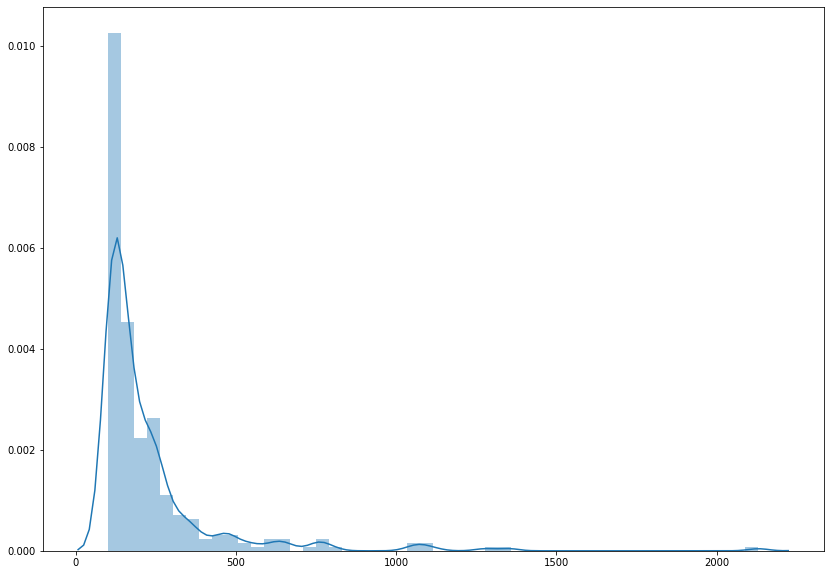

In [12]:
%%time

filename = '/data/augmentation/ngram_dist/SQuAD_3gram_distribution.pickle.gz'

with gzip.GzipFile(filename, 'rb') as f:
    fdist_gz = cPickle.load(f)
    
plt.figure(figsize=(14,10))
ngram_freq = [freq for freq in fdist_gz.values() if freq > 100]
sns.distplot(ngram_freq);

In [ ]:
def save(object, filename, protocol = 4):
        """Saves a compressed object to disk
        """
        file = gzip.GzipFile(filename, 'wb')
        file.write(pickle.dumps(object, protocol))
        file.close()

def load(filename):
        """Loads a compressed object from disk
        """
        file = gzip.GzipFile(filename, 'rb')
        buffer = ""
        while True:
                data = file.read()
                if data == "":
                        break
                buffer += data
        object = pickle.loads(buffer)
        file.close()
        return object
    
dist_from_pickle = load(filename)